### 1a)

In [34]:
# load in the source data
options(jupyter.plot_mimetypes = 'image/png')
set.seed(123)
library(geoR)
library(sp)
library(rgdal)
library(maptools)
library(splancs)
library(spatstat)
library(lattice)
library(SpatialEpi)
library(sp)
library(Matrix)
library(splines)
library(RColorBrewer)
library(maps)
library(maptools)
library(classInt)
library(ggplot2)
library(foreign)
library(mgcv)
data("ca20")

variog: computing omnidirectional variogram


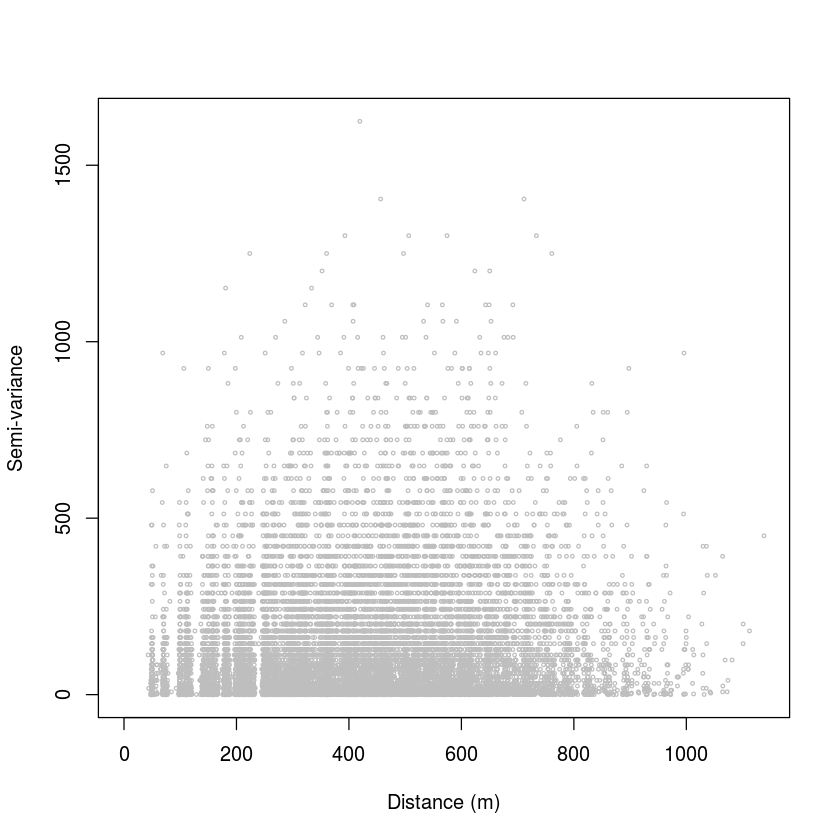

In [2]:
cloudca20 <- variog(ca20, option = "cloud")
plot(cloudca20, ylab = "Semi-variance", xlab = "Distance (m)",
     col = "grey", cex = 0.4)

variog: computing omnidirectional variogram


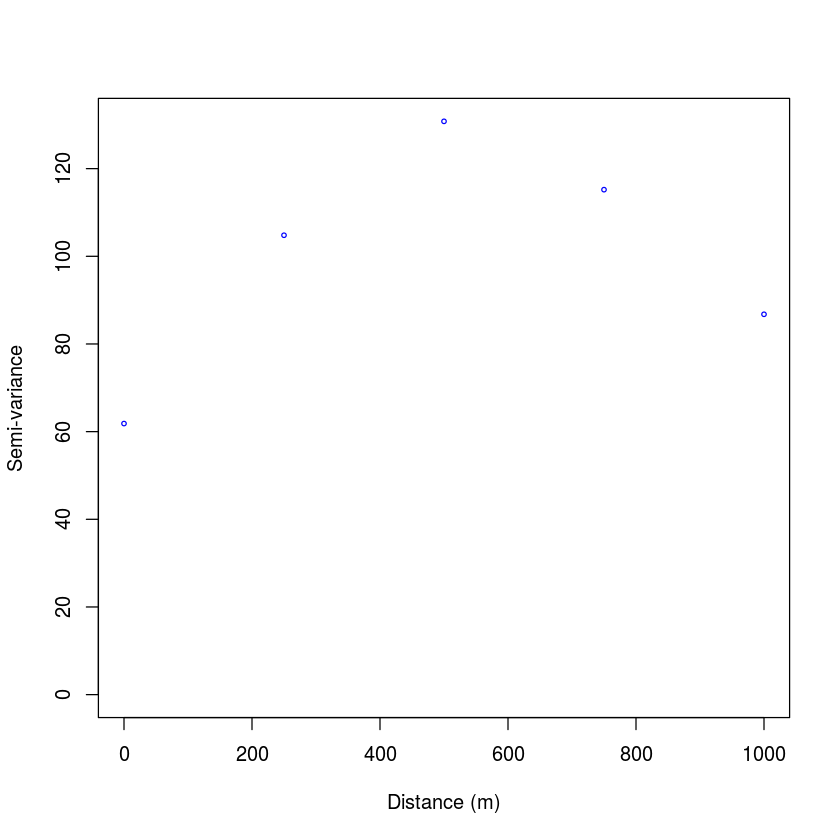

In [3]:
binca20 <- variog(ca20, uvec = seq(0,5000, 250), 
                  trend = ~ca20$covariate$altitude)
plot(binca20, ylab = "Semi-variance", xlab = "Distance (m)",
     cex = 0.5, col = "blue")

### 1b)

variog.env: generating 99 simulations by permutating data values
variog.env: computing the empirical variogram for the 99 simulations
variog.env: computing the envelops


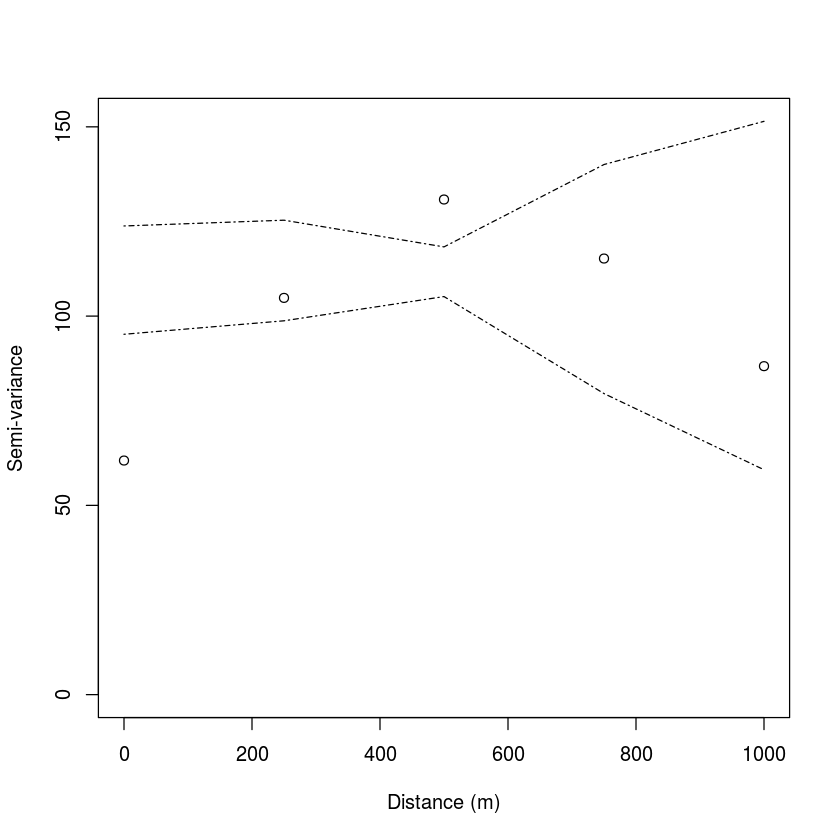

In [4]:
ca20.env <- variog.mc.env(ca20, obj = binca20)
plot(binca20, env = ca20.env, xlab = "Distance (m)",ylab = "Semi-variance")

### 1c)

In [5]:
olsfit <- variofit(binca20, ini = c(50, 50), weights = "equal")
olsfit

variofit: covariance model used is matern 
variofit: weights used: equal 
variofit: minimisation function used: optim 


variofit: model parameters estimated by OLS (ordinary least squares):
covariance model is: matern with fixed kappa = 0.5 (exponential)
parameter estimates:
  tausq sigmasq     phi 
61.7763 48.4090 88.4765 
Practical Range with cor=0.05 for asymptotic range: 265.052

variofit: minimised sum of squares = 1011.59

In [6]:
mlfit <- likfit(ca20, ini = c(50, 50), trend = ~ca20$covariate$altitude, 
                messages=FALSE)
remlfit <- likfit(ca20, ini = c(50,50), lik.method = "RML", trend = ~ca20$covariate$altitude, 
                  messages=FALSE)
print("maximum likelihood")
mlfit$parameters.summary
print("restricted maximum likelihood")
remlfit$parameters.summary

[1] "maximum likelihood"


,status,values
beta0,estimated,39.1632
beta1,estimated,2.0209
tausq,estimated,15.997
sigmasq,estimated,128.1412
phi,estimated,147.0894
kappa,fixed,0.5
psiA,fixed,0
psiR,fixed,1
lambda,fixed,1


[1] "restricted maximum likelihood"


,status,values
beta0,estimated,40.151
beta1,estimated,1.8781
tausq,estimated,18.9967
sigmasq,estimated,149.9804
phi,estimated,191.6871
kappa,fixed,0.5
psiA,fixed,0
psiR,fixed,1
lambda,fixed,1


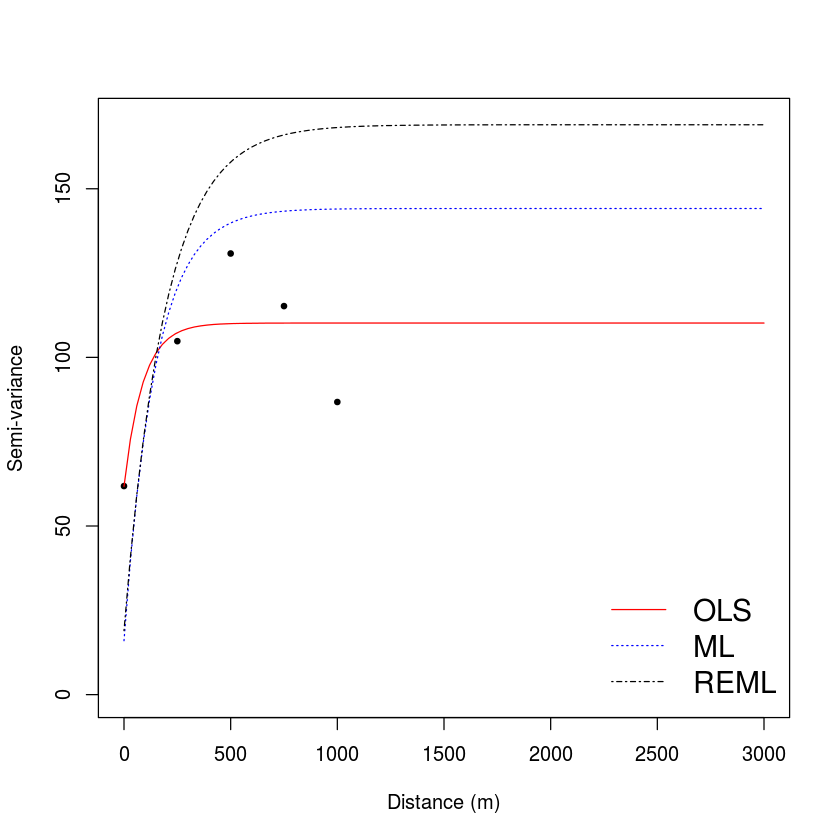

In [7]:
plot(binca20, max.dist = 3000, xlab = "Distance (m)",ylab = "Semi-variance", 
     pch = 19, cex = 0.6, ylim= c(0,170))
lines(olsfit, max.dist = 3000, col = "red")
lines(mlfit, max.dist = 3000, lty = 3, col = "blue")
lines(remlfit, max.dist = 3000, lty = 4, col = "black")
legend("bottomright", legend = c("OLS", "ML", "REML"), lty = c(1, 3, 4), bty = "n", 
       col = c("red", "blue", "black"), cex = 1.5)

### 1d) Kriging

In [8]:
lmfit <- lm(ca20$data ~ ca20$covariate$altitude)
detrend <- as.geodata(cbind(ca20$coords, lmfit$residuals))
mlfit2 <- likfit(detrend, ini = c(50, 50), messages=FALSE)

In [9]:
pred.grid <- expand.grid(seq(4800, 6000,l = 51), seq(4800, 5800, l = 51))
kc <- krige.conv(detrend, loc = pred.grid, krige = krige.control(obj.m = mlfit2))

krige.conv: model with constant mean
krige.conv: Kriging performed using global neighbourhood 


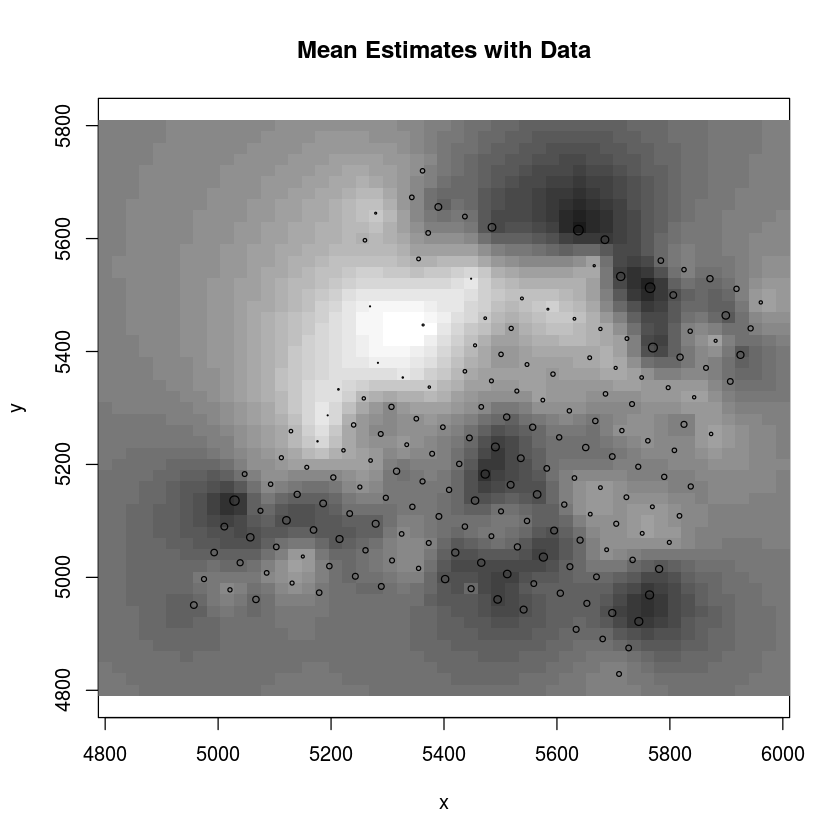

In [10]:
image(kc, loc=pred.grid, val=kc$predict, col=gray(seq(1,.1,l=30)),
      xlab="x",ylab="y", main="Mean Estimates with Data")
symbols(detrend$coords[,1], detrend$coords[,2],
        circles=(detrend$data-min(detrend$data))/1,
        add=TRUE, inches=0.04)

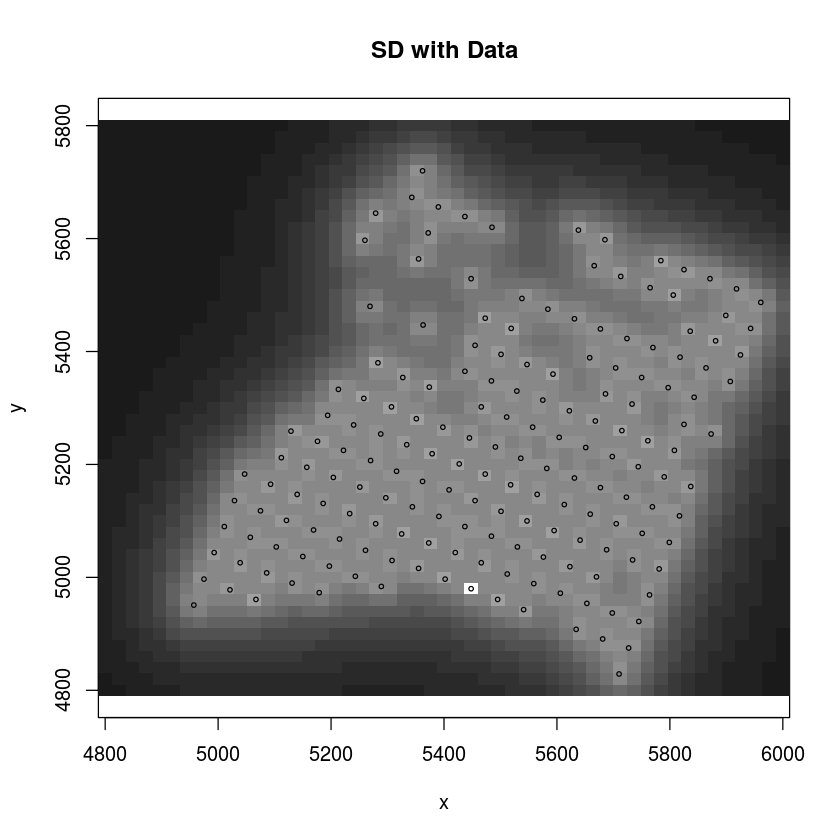

In [11]:
image(kc, val=sqrt(kc$krige.var), col=gray(seq(1,.1,l=30)), 
      xlab="x", ylab="y", main="SD with Data")
points(detrend$coords[,1], detrend$coords[,2], cex=.5)

### 2a)

In [3]:
setwd("../hw1")
source("AlaskaScript.R", echo=FALSE)
setwd("../hw4")
alaska <- subset(x, ASTHMA != -999)

In [4]:
pointdf <- SpatialPointsDataFrame(coords=alaska[,c("X_COORD", "Y_COORD")],
                                  data=alaska[,c("MOLD","ASTHMA")])

In [5]:
bwasthma <- 0.06
pppasthma <- as(pointdf, "ppp")

In [6]:
#marks(pppasthma) <- relevel(pppasthma$marks$Asthma, "control")
cases <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 1))
ncases <- npoints(cases)
controls <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 0))
ncontrols <- npoints(controls)

In [7]:
kcases <- density(cases, bwasthma)
kcontrols <- density(controls, bwasthma)
spkratio0 <- as(kcases, "SpatialGridDataFrame")
names(spkratio0) <- "kcases"
spkratio0$kcontrols <- as(kcontrols, "SpatialGridDataFrame")$v
spkratio <- as(spkratio0, "SpatialPixelsDataFrame")
spkratio$kratio <- (spkratio$kcases + .00000001)/(spkratio$kcontrols + .00000001)
spkratio$krationorm <- spkratio$kratio/(ncases/ncontrols)
spkratio$logratio <-log(spkratio$kratio)-log(ncases/ncontrols)

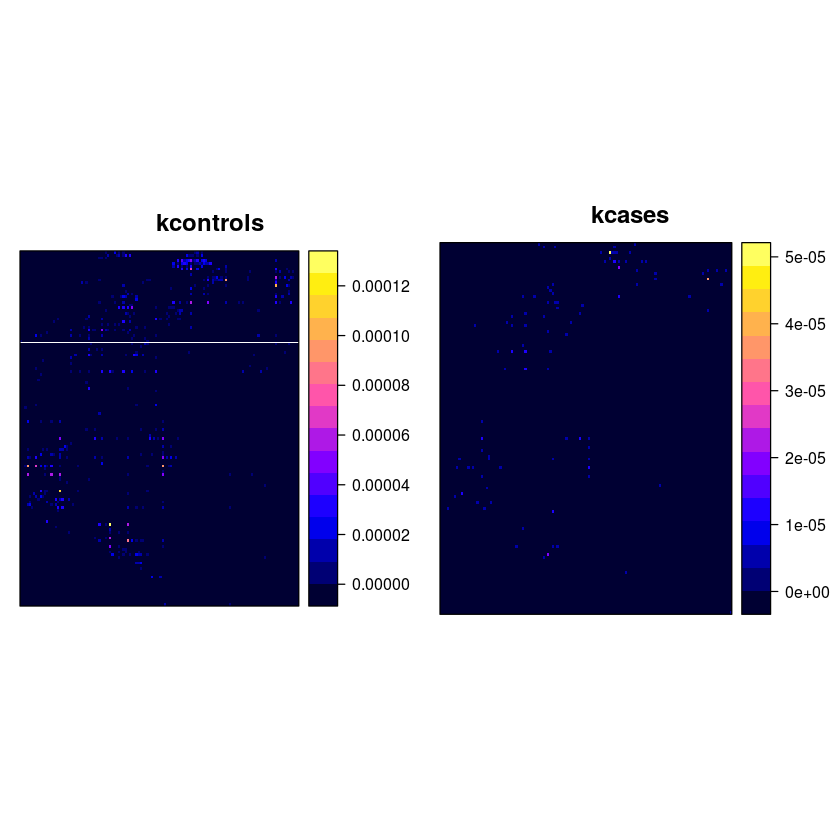

In [8]:
p1 <- spplot(spkratio, "kcontrols", main="kcontrols")
p2 <- spplot(spkratio, "kcases", main="kcases")
p3 <- spplot(spkratio, "kratio", main="kratio")

print(p1, position=c(0, 0, .5, 1), more=T)
print(p2, position=c(.5, 0, 1, 1))

### 2b) 

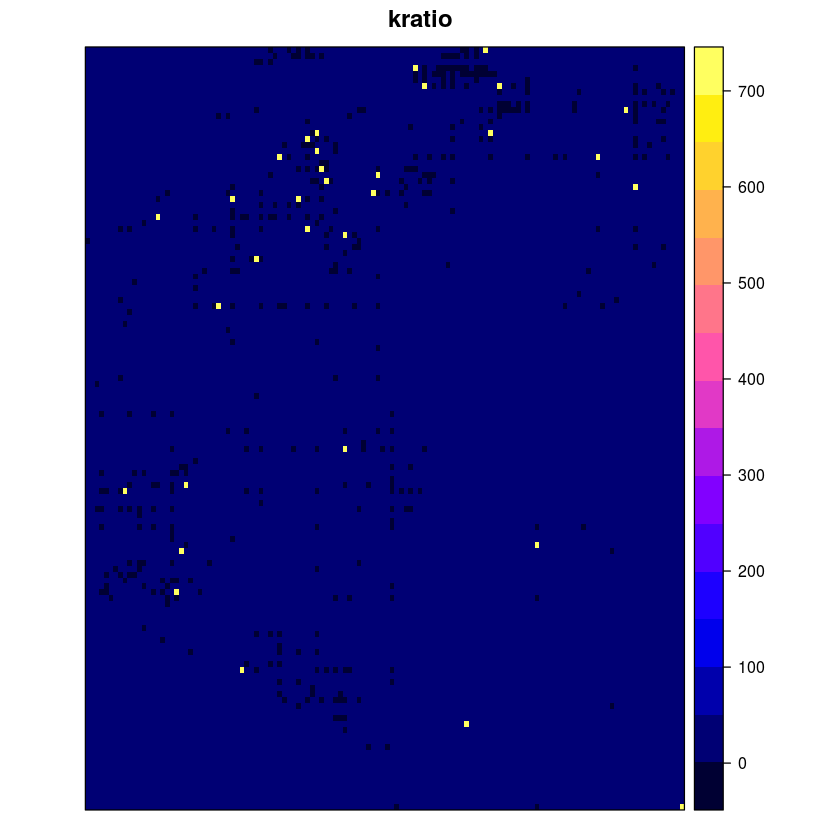

In [10]:
spplot(spkratio, "kratio", main="kratio")

In [28]:
test_bandwith <- function(bwasthma, p = pointdf){
    pppasthma <- as(pointdf, "ppp")
    cases <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 1))
    ncases <- npoints(cases)
    controls <- unmark(subset(pppasthma, marks(pppasthma)$ASTHMA == 0))
    ncontrols <- npoints(controls)
    kcases <- density(cases, bwasthma)
    kcontrols <- density(controls, bwasthma)
    spkratio0 <- as(kcases, "SpatialGridDataFrame")
    names(spkratio0) <- "kcases"
    spkratio0$kcontrols <- as(kcontrols, "SpatialGridDataFrame")$v
    spkratio <- as(spkratio0, "SpatialPixelsDataFrame")
    spkratio$kratio <- (spkratio$kcases + .00000001)/(spkratio$kcontrols + .00000001)
    spkratio$krationorm <- spkratio$kratio/(ncases/ncontrols)
    spkratio$logratio <-log(spkratio$kratio)-log(ncases/ncontrols)
    spkratio
}

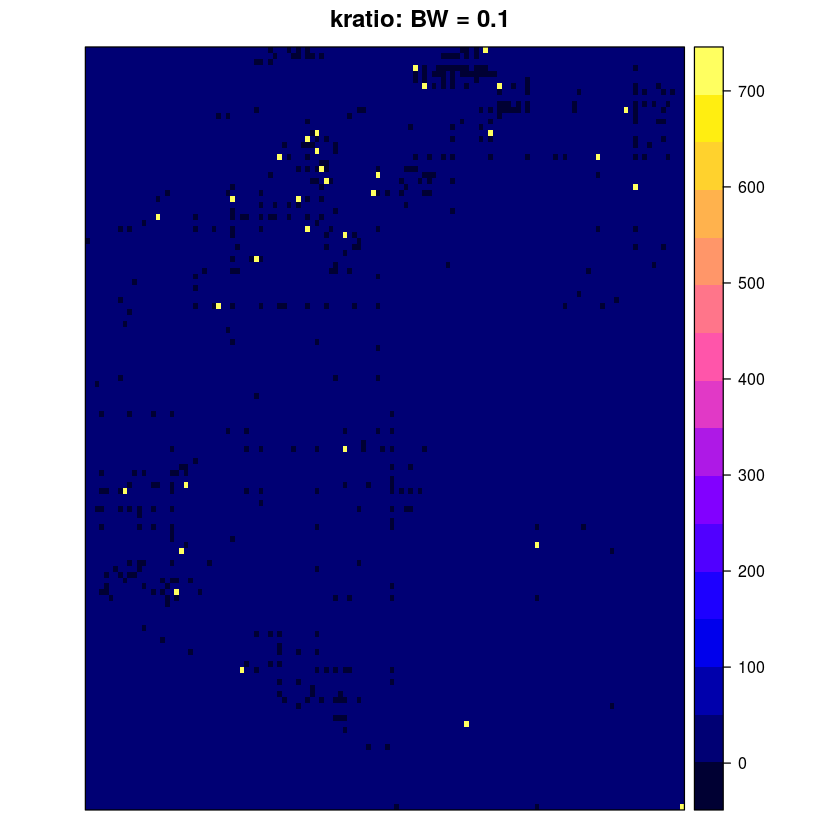

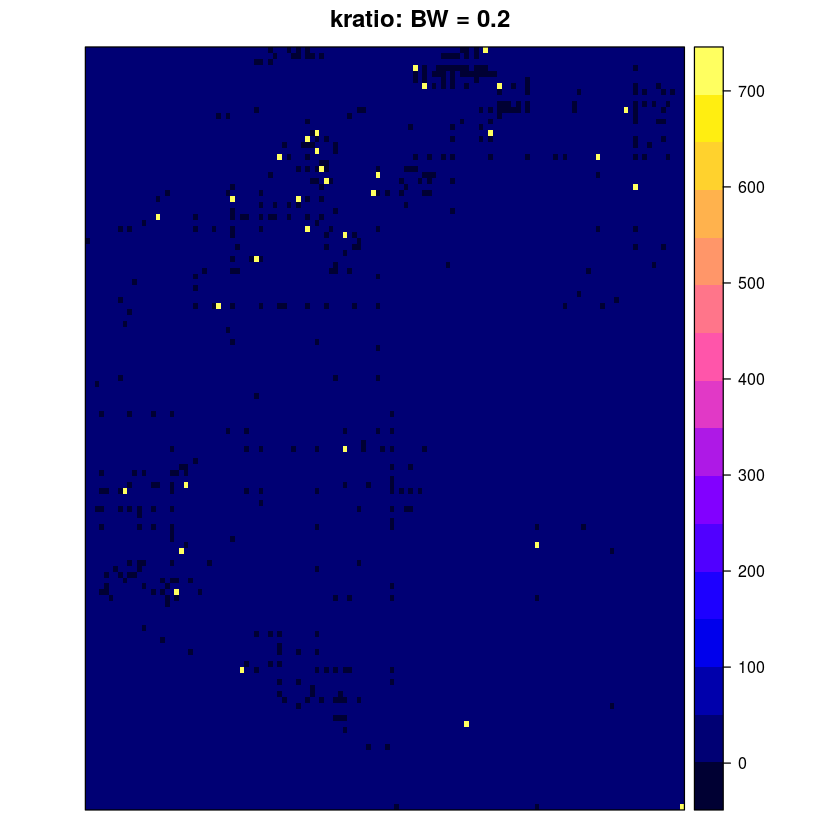

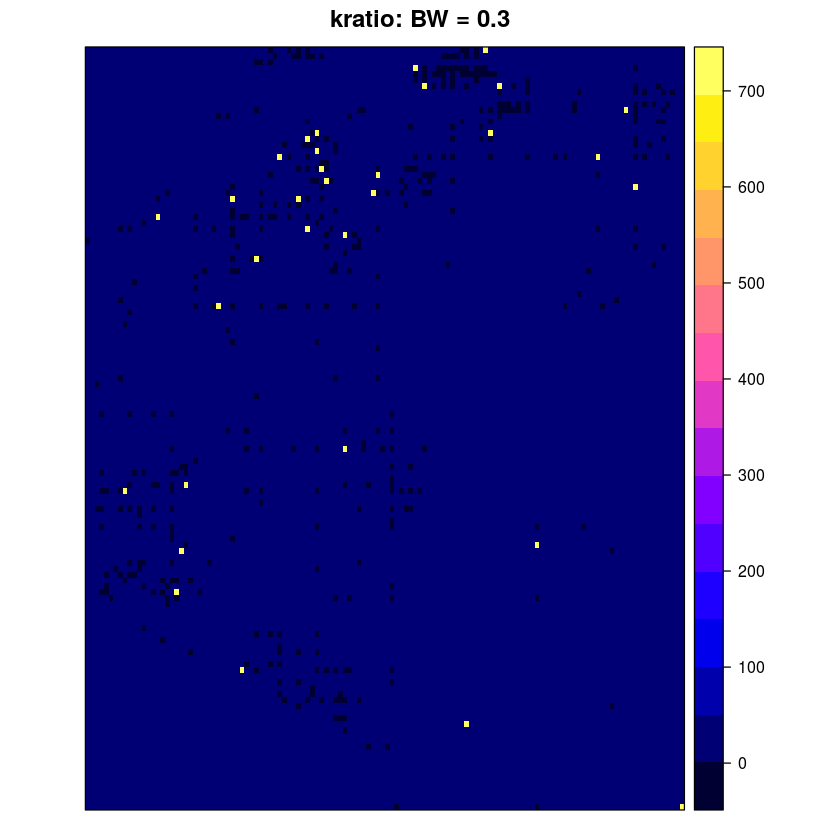

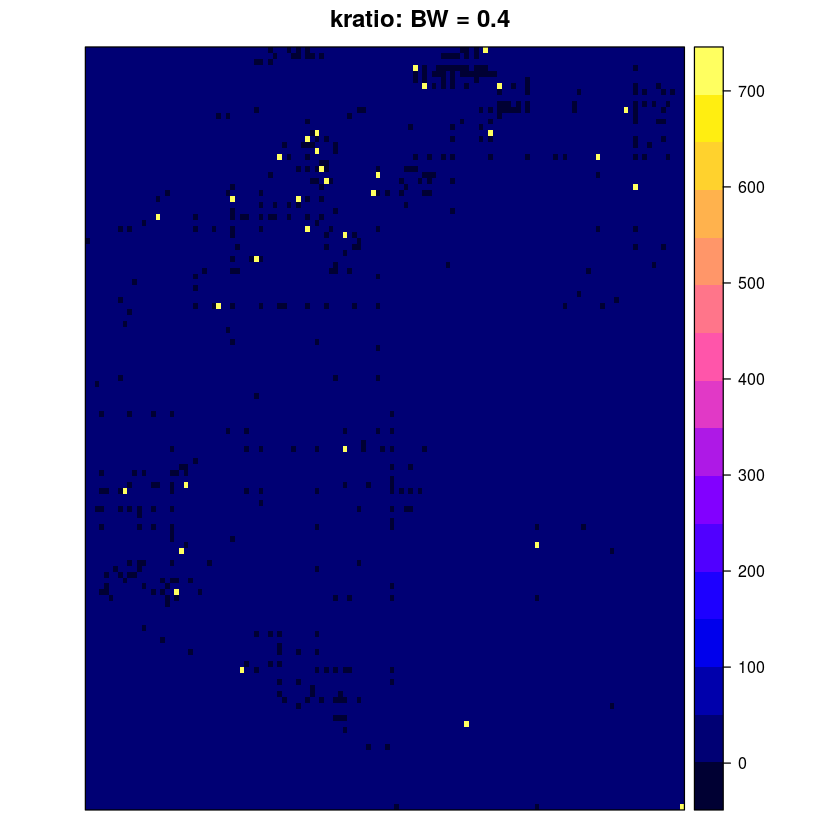

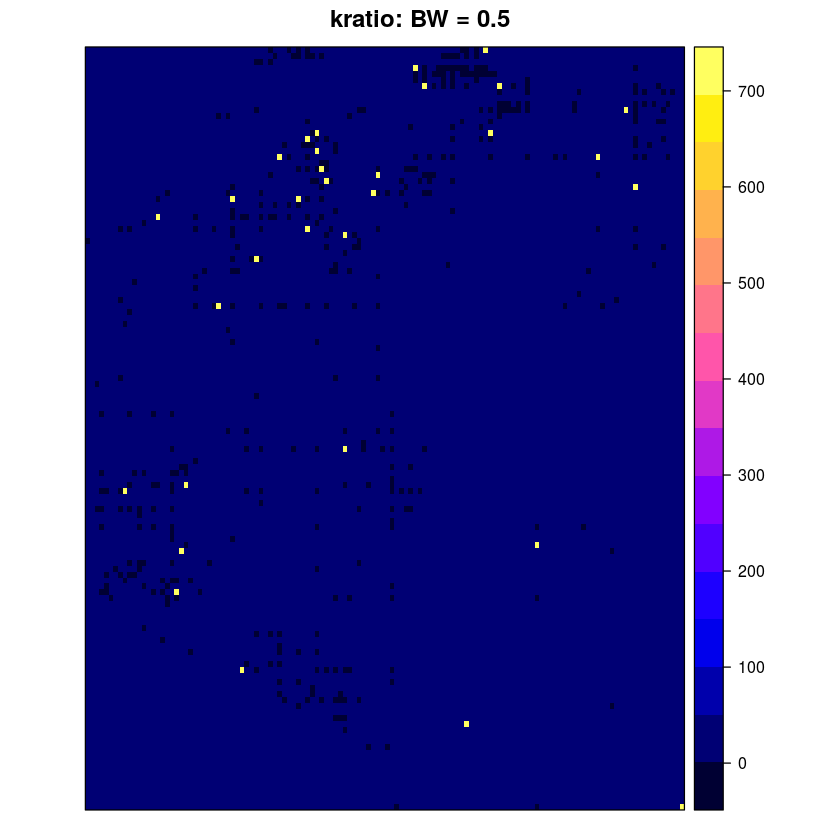

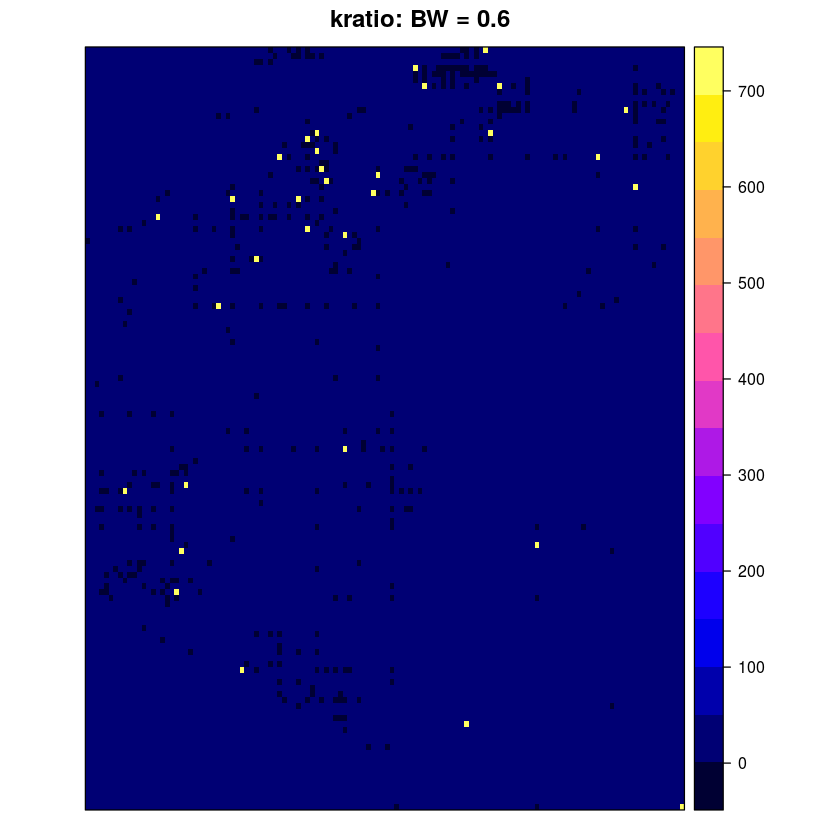

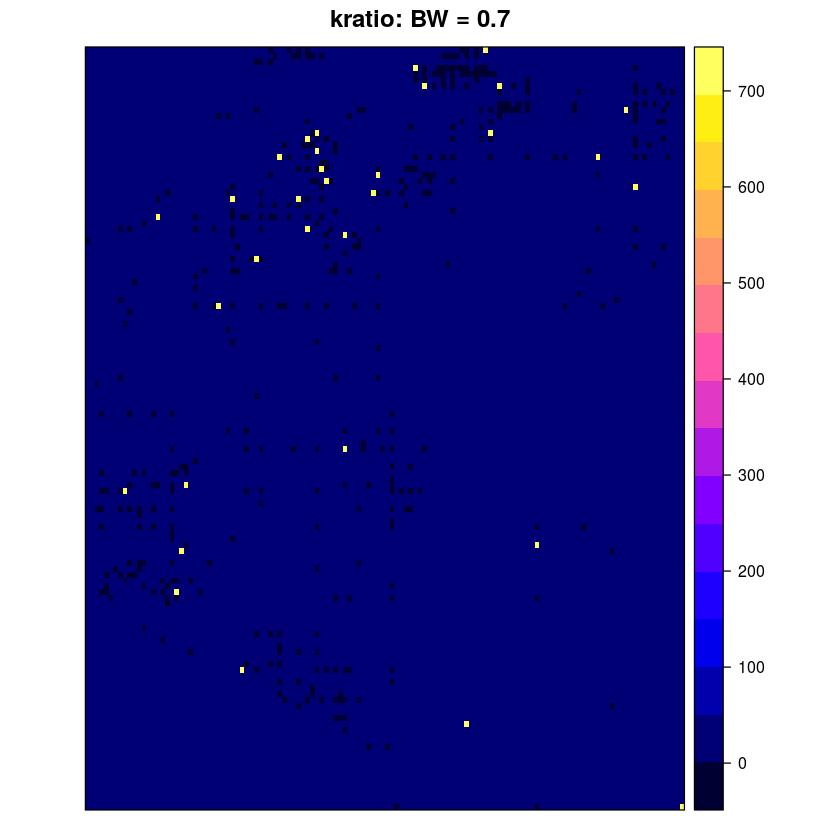

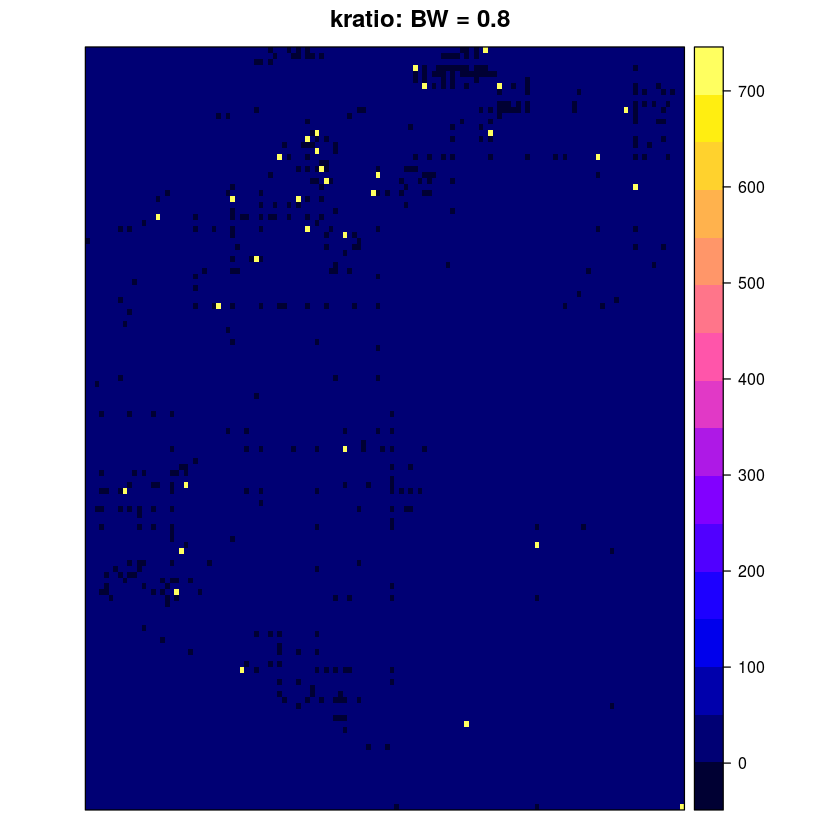

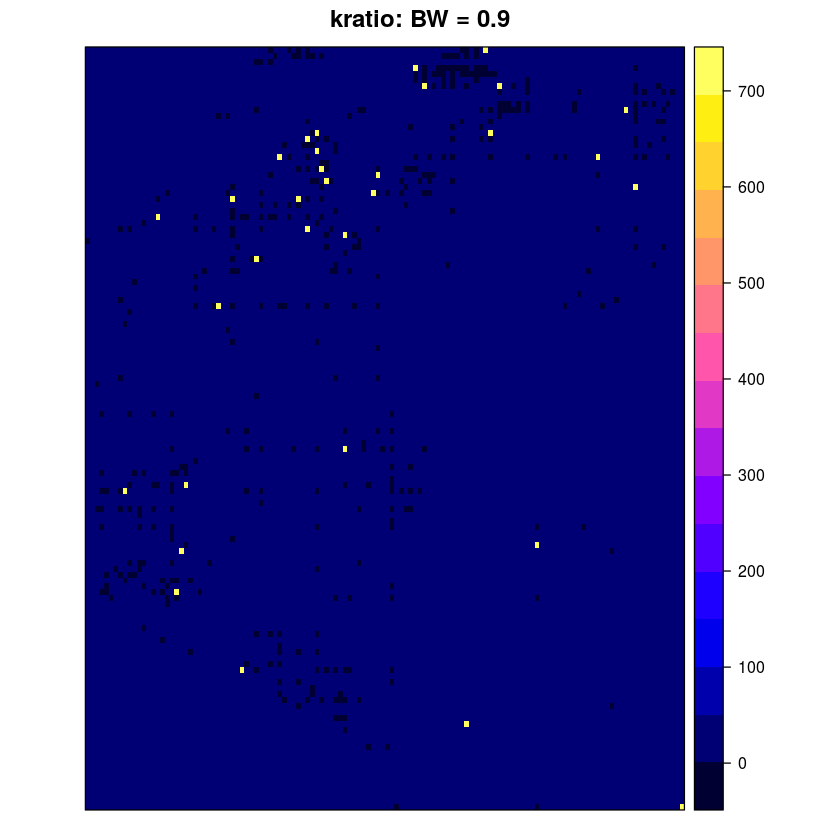

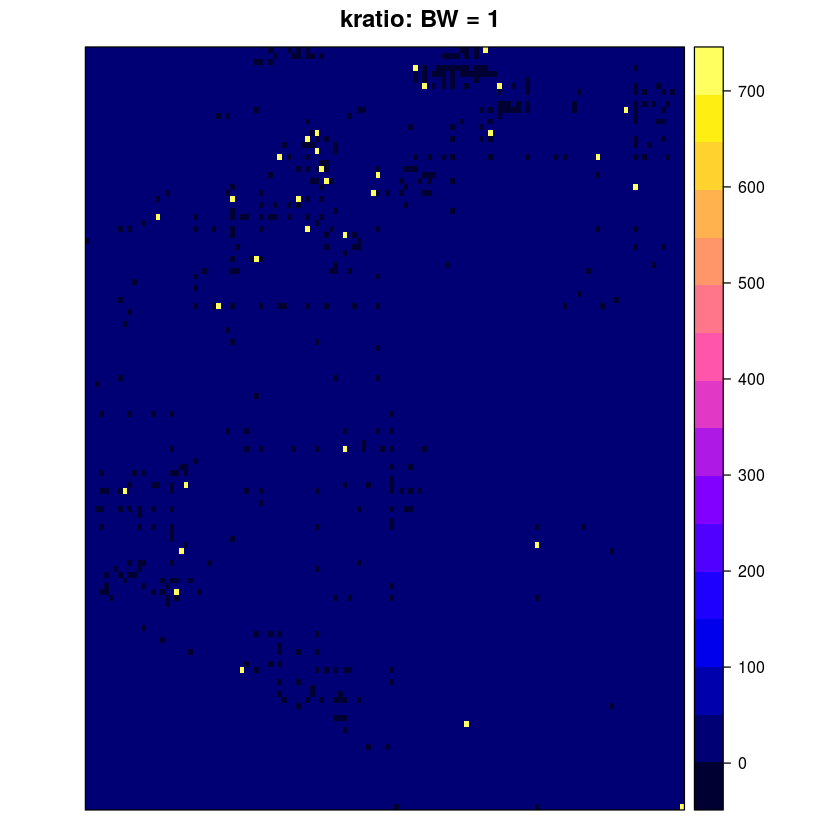

In [32]:
for (i  in (1:10 / 10)){
    spkratio_sub <- test_bandwith(bwasthma=i, p = pointdf)
    p_sub <- spplot(spkratio_sub, "kratio", main=paste0("kratio: BW = ", i))
    print(p_sub)
}

### 2d) 

In [36]:
ccasthma <- coordinates(pointdf)
pointdf@data <- cbind(pointdf@data, ccasthma)

In [45]:
alaska$EXPOSURE <- 10*alaska[,60]/max(alaska[,60])

In [48]:
summary(glm(ASTHMA ~ EXPOSURE, data=alaska, family="binomial"))


Call:
glm(formula = ASTHMA ~ EXPOSURE, family = "binomial", data = alaska)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5901  -0.4983  -0.4751  -0.4667   2.1328  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.16576    0.13385 -16.180   <2e-16 ***
EXPOSURE     0.05060    0.04583   1.104     0.27    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 763.19  on 1085  degrees of freedom
Residual deviance: 762.01  on 1084  degrees of freedom
AIC: 766.01

Number of Fisher Scoring iterations: 4


### 2e) 

In [50]:
summary(glm(ASTHMA ~ EXPOSURE + X_COORD + Y_COORD, data=alaska, family="binomial"))


Call:
glm(formula = ASTHMA ~ EXPOSURE + X_COORD + Y_COORD, family = "binomial", 
    data = alaska)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5853  -0.5156  -0.4842  -0.4316   2.3412  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept) -3.170e+01  1.799e+01  -1.762   0.0781 .
EXPOSURE     4.523e-02  4.575e-02   0.989   0.3229  
X_COORD     -3.849e-06  1.097e-05  -0.351   0.7258  
Y_COORD      1.204e-05  7.891e-06   1.525   0.1272  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 763.19  on 1085  degrees of freedom
Residual deviance: 759.18  on 1082  degrees of freedom
AIC: 767.18

Number of Fisher Scoring iterations: 5


### 2f)

In [54]:
summary(gam(ASTHMA ~ EXPOSURE + s(X_COORD, Y_COORD), family=binomial, data=alaska))


Family: binomial 
Link function: logit 

Formula:
ASTHMA ~ EXPOSURE + s(X_COORD, Y_COORD)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.16646    0.13407 -16.159   <2e-16 ***
EXPOSURE     0.04523    0.04575   0.988    0.323    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df Chi.sq p-value
s(X_COORD,Y_COORD) 2.002  2.004   2.75   0.253

R-sq.(adj) =  0.00138   Deviance explained = 0.526%
UBRE = -0.29357  Scale est. = 1         n = 1086